# Death Proximity Classification — Minimal Feature Model

In this notebook, we predict whether a behavioral segment is **close to death**
using a **small number of hand-crafted “aging” features**.

We compare performance (F1, AUC, Accuracy) for:
- 1 feature
- 2 features
- 3 features
- 4 features
- 6 features
- the full set of aging-related features

Cross-validation is stratified **by worm**, avoiding any leakage.



In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt

print("✓ Imports loaded.")


✓ Imports loaded.


Charger le dataset de features:
- Charge le CSV contenant les features par segment (généré par l’assistant du prof).
- Affiche le nombre de lignes (= nombre de segments).
- Montre les premières lignes pour vérifier les colonnes.

In [12]:
FEATURE_FILE = "feature_data/segments_features.csv"

df = pd.read_csv(FEATURE_FILE)
print(f"Loaded segments: {len(df)}")
df.head()

Loaded segments: 8197


,mean_speed,std_speed,max_speed,min_speed,total_distance,time_paused,fraction_paused,mean_turning_angle,std_turning_angle,max_turning_angle,...,turning_dominant_freq,turning_spectral_centroid,activity_level,high_activity_fraction,low_activity_fraction,mixed_activity_fraction,filename,label,segment_index,original_file
0,0.515196,0.822250,8.953392,0.000000,0.309186,85,0.094549,0.010376,0.591906,1.000000,...,79,222.292989,0.187359,0.000000,0.000000,0.000000,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
1,0.358384,0.386695,3.983101,0.000000,0.215078,89,0.098999,-0.039617,0.549625,1.000000,...,272,217.160606,0.196802,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
2,0.450613,0.681019,10.000000,0.000000,0.375546,54,0.060067,0.029493,0.519526,1.000000,...,227,223.010712,0.154898,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
3,1.142944,1.318301,10.000000,0.000000,1.735031,9,0.010011,0.003154,0.552685,0.999678,...,352,229.228829,0.210105,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...
4,2.279008,2.123586,10.000000,0.029532,1.563521,4,0.004449,0.006558,0.478620,0.997902,...,338,227.525328,0.256524,0.250557,0.250557,0.498886,coordinates_highestspeed_20250311_19_2_with_ti...,0,NaN,coordinates_highestspeed_20250311_19_2_with_ti...


Reconstruire segment_index et segments_from_end + label 
- Reconstruit segment_index à partir du nom du fichier si la colonne est absente.
- Pour chaque ver (original_file), récupère l’index du dernier segment. 
- Calcule segments_from_end = combien de segments il reste avant la mort pour chaque segment.
- Crée le label binaire :
    - 1 si le segment est dans les 20 derniers segments,
    - 0 sinon.

- Stocke :
    - y = labels,
    - groups = id du ver (pour split sans fuite).

Affiche la distribution des labels (important pour voir le déséquilibre de classes).

In [13]:
# segment_index à partir du nom de fichier si besoin
if "segment_index" not in df.columns or df["segment_index"].isna().all():
    df["segment_index"] = df["filename"].str.extract(
        r"segment(\d+(?:\.\d+)?)", expand=False
    ).astype(float)

df["original_file"] = df["original_file"].astype(str)

# distance à la mort en nombre de segments
max_seg = df.groupby("original_file")["segment_index"].max()

df["segments_from_end"] = df.apply(
    lambda row: max_seg[row["original_file"]] - row["segment_index"],
    axis=1
)

# label binaire : proche de la mort ou pas
PROXIMITY_THRESHOLD = 20  # segments
df["close_to_death"] = (df["segments_from_end"] <= PROXIMITY_THRESHOLD).astype(int)

y = df["close_to_death"].values
groups = df["original_file"].values

print("Label distribution (0=not near-death, 1=near-death):", np.bincount(y))
df[["segment_index", "segments_from_end", "close_to_death"]].head()


Label distribution (0=not near-death, 1=near-death): [6061 2136]


,segment_index,segments_from_end,close_to_death
0,0.0,108.0,0
1,1.0,107.0,0
2,2.0,106.0,0
3,3.0,105.0,0
4,4.0,104.0,0


Definir les subsets de features:
- Liste toutes les features d’aging calculées par l’assistant.
- Restreint à celles qui existent effectivement dans le CSV (available_features).
- Définit un petit set ordonné de features “noyau” (ranked_core) :
    - vitesse moyenne,
    - entropie de vitesse,
    - score de roaming,
    - fraction de temps en pause,
    - efficacité de mouvement,
    - fraction de haute activité.

Crée plusieurs subsets :
- 1 feature, 2, 3, 4, 6, toutes.

Affiche clairement quelles features sont utilisées dans chaque subset.

In [14]:
# Ensemble complet de features "aging" fournies par l'assistant
top_aging_features = [
    "high_activity_fraction", "mixed_activity_fraction", "low_activity_fraction",
    "mean_speed", "std_speed", "max_speed", "speed_entropy",
    "mean_roaming_score", "std_roaming_score", "fraction_roaming",
    "movement_efficiency", "fraction_efficient_movement",
    "time_paused", "fraction_paused",
    "mean_jerk", "max_jerk", "kinetic_energy_proxy",
    "mean_meandering_ratio", "std_meandering_ratio",
    "wavelet_speed_level0", "wavelet_speed_level1", "wavelet_speed_level2", "wavelet_speed_level3",
    "mean_frenetic_score", "std_frenetic_score",
    "speed_persistence", "activity_level", "speed_skewness", "speed_kurtosis"
]

available_features = [f for f in top_aging_features if f in df.columns]

# Features les plus "centrales" pour l'aging / near-death
ranked_core = [
    "mean_speed",
    "speed_entropy",
    "mean_roaming_score",
    "fraction_paused",
    "movement_efficiency",
    "high_activity_fraction"
]

feature_subsets = {
    "1_feature": ranked_core[:1],
    "2_features": ranked_core[:2],
    "3_features": ranked_core[:3],
    "4_features": ranked_core[:4],
    "6_features": ranked_core[:6],
    "all_top_aging": available_features,
}

print("=== FEATURE SUBSETS USED ===\n")
for name, feats in feature_subsets.items():
    print(f"{name:15s} ({len(feats)} features):")
    for f in feats:
        print(f"   - {f}")
    print()


=== FEATURE SUBSETS USED ===

1_feature       (1 features):
   - mean_speed

2_features      (2 features):
   - mean_speed
   - speed_entropy

3_features      (3 features):
   - mean_speed
   - speed_entropy
   - mean_roaming_score

4_features      (4 features):
   - mean_speed
   - speed_entropy
   - mean_roaming_score
   - fraction_paused

6_features      (6 features):
   - mean_speed
   - speed_entropy
   - mean_roaming_score
   - fraction_paused
   - movement_efficiency
   - high_activity_fraction

all_top_aging   (29 features):
   - high_activity_fraction
   - mixed_activity_fraction
   - low_activity_fraction
   - mean_speed
   - std_speed
   - max_speed
   - speed_entropy
   - mean_roaming_score
   - std_roaming_score
   - fraction_roaming
   - movement_efficiency
   - fraction_efficient_movement
   - time_paused
   - fraction_paused
   - mean_jerk
   - max_jerk
   - kinetic_energy_proxy
   - mean_meandering_ratio
   - std_meandering_ratio
   - wavelet_speed_level0
   - wavelet_

Evaluation: Cross Val par worm 
- Définit une fonction utilitaire evaluate_feature_subsets qui :
    - prend le DataFrame, les labels, les groupes, et le dict de subsets,
    - pour chaque subset :
        - récupère les colonnes correspondantes,
        - remplace les NaNs par la médiane (par feature),
        - construit un Pipeline :
            - StandardScaler → normalisation,
            - GradientBoostingClassifier → modèle non linéaire robuste,
        - fait une StratifiedGroupKFold :
            - strates = label (équilibrage),
            - groupes = worm (pas de fuite),
        - calcule F1 / Accuracy / AUC à chaque fold,
        - stocke les moyennes.
    - Retourne un DataFrame de résultats, trié par nombre de features.

In [16]:
def evaluate_feature_subsets(df, y, groups, feature_subsets, n_splits=5, random_state=42):
    """
    Effectue une cross-validation groupée (par ver) pour chaque subset de features.
    Retourne un DataFrame avec F1, AUC, Accuracy moyens.
    """
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []

    for name, feats in feature_subsets.items():
        print(f"\n--- Testing subset: {name} ({len(feats)} features) ---")

        X = df[feats].copy()
        X = X.fillna(X.median(numeric_only=True))

        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("gb", GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.05,
                max_depth=6,
                random_state=random_state
            ))
        ])

        f1s, accs, aucs = [], [], []

        for train_idx, test_idx in cv.split(X, y, groups):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]

            clf.fit(X_tr, y_tr)

            proba = clf.predict_proba(X_te)[:, 1]
            preds = (proba >= 0.5).astype(int)

            f1s.append(f1_score(y_te, preds))
            accs.append(accuracy_score(y_te, preds))
            aucs.append(roc_auc_score(y_te, proba))

        results.append({
            "subset": name,
            "n_features": len(feats),
            "F1_mean": np.mean(f1s),
            "ACC_mean": np.mean(accs),
            "AUC_mean": np.mean(aucs),
        })

    results_df = pd.DataFrame(results).sort_values("n_features")
    return results_df


Lance l'evaluation et affiche les resultats: 

In [17]:
results_df = evaluate_feature_subsets(df, y, groups, feature_subsets, n_splits=5, random_state=42)

print("\n=== RESULTS (Minimal Feature Model) ===\n")
for _, r in results_df.iterrows():
    print(
        f"{r['subset']:15s} | "
        f"{int(r['n_features']):2d} feats | "
        f"F1={r['F1_mean']:.3f} | "
        f"AUC={r['AUC_mean']:.3f} | "
        f"ACC={r['ACC_mean']:.3f}"
    )

results_df


--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing subset: 6_features (6 features) ---

--- Testing subset: all_top_aging (29 features) ---

=== RESULTS (Minimal Feature Model) ===

1_feature       |  1 feats | F1=0.530 | AUC=0.790 | ACC=0.766
2_features      |  2 feats | F1=0.520 | AUC=0.811 | ACC=0.763
3_features      |  3 feats | F1=0.521 | AUC=0.811 | ACC=0.764
4_features      |  4 feats | F1=0.514 | AUC=0.811 | ACC=0.760
6_features      |  6 feats | F1=0.502 | AUC=0.811 | ACC=0.759
all_top_aging   | 29 feats | F1=0.529 | AUC=0.820 | ACC=0.768


,subset,n_features,F1_mean,ACC_mean,AUC_mean
0,1_feature,1,0.529918,0.765743,0.790479
1,2_features,2,0.519876,0.763424,0.810700
2,3_features,3,0.520641,0.763561,0.811288
3,4_features,4,0.514110,0.760427,0.810950
4,6_features,6,0.502084,0.758742,0.811207
5,all_top_aging,29,0.529138,0.768254,0.820055


remarque: F1 ~0.52 pour 1 à 29 features, AUC ~0.79–0.82

Petit plot pour visualiser: 

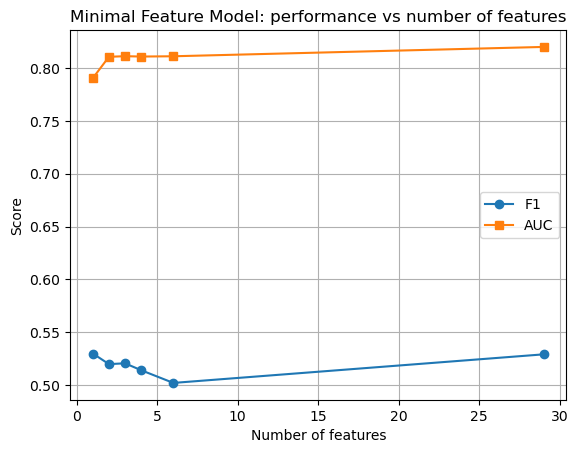

In [22]:
# === Plot: performance vs number of features ===

plt.figure()
plt.plot(results_df["n_features"], results_df["F1_mean"], marker="o", label="F1")
plt.plot(results_df["n_features"], results_df["AUC_mean"], marker="s", label="AUC")
plt.xlabel("Number of features")
plt.ylabel("Score")
plt.title("Minimal Feature Model: performance vs number of features")
plt.legend()
plt.grid(True)
plt.show()



Using only one feature (mean speed) already gives an F1-score around 0.53 and an AUC around 0.79.
Extending the feature set to 2–6 features (adding speed entropy, roaming score, fraction paused, movement efficiency, high activity fraction) does not significantly change the F1-score and increases AUC only marginally.
The full 29-feature model reaches an AUC ≈ 0.82, suggesting that a small set of 3–6 features captures most of the predictive signal.

Importance des features pour un subset choisi (un peu comme ce que l'assistant a deja fait en vrai )

In [23]:
# === Feature importance analysis for a chosen subset ===

subset_for_importance = "6_features"  # ou "all_top_aging", comme tu veux
feats = feature_subsets[subset_for_importance]

print(f"Computing feature importances for subset: {subset_for_importance}")
print("Features:", feats)

X_imp = df[feats].copy()
X_imp = X_imp.fillna(X_imp.median(numeric_only=True))
y_imp = df["close_to_death"].values

gb_imp = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

gb_imp.fit(X_imp, y_imp)

importances = gb_imp.feature_importances_
sorted_feats = sorted(zip(feats, importances), key=lambda x: -x[1])

print("\n=== Feature importances (Gradient Boosting) ===")
for f, w in sorted_feats:
    print(f"{f:30s} {w:.4f}")


Computing feature importances for subset: 6_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score', 'fraction_paused', 'movement_efficiency', 'high_activity_fraction']

=== Feature importances (Gradient Boosting) ===
mean_roaming_score             0.4788
mean_speed                     0.2062
speed_entropy                  0.1441
fraction_paused                0.0940
movement_efficiency            0.0628
high_activity_fraction         0.0140


remarque pourquoi la c'est mean_roaming_score le plus important wtf? 

COMPARER PLUSIEURS MODELES SUR LE MEILLEUR SUBSET 
on choisi le subset qu'on veut et on teste avec des methodes differentes:
- GradientBoosting 
- Logistic Regression
- Linear SVM calibré (pour obtenir des probabilités, donc un AUC)

In [25]:
# === Model comparison on a chosen feature subset ===

subset_for_models = "3_features"  # A CHANGER AVEC LES SUBSET QU'ON VEUT
feats = feature_subsets[subset_for_models]

print(f"Model comparison using subset: {subset_for_models}")
print("Features:", feats)

X_all = df[feats].copy().fillna(df[feats].median(numeric_only=True))
y_all = df["close_to_death"].values
groups_all = df["original_file"].values

# Split train/test par ver -> J'AIMERAI BIEN FAIRE UNE FONCTION POUR CE TRUC QUE J'AI JUSTE A RAPPELER DE TEMPS A AUTRE 
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
train_idx, test_idx = next(gss.split(X_all, y_all, groups=groups_all))

X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

models = {
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        random_state=42
    ),
    "LinearSVM": CalibratedClassifierCV(
        LinearSVC(
            C=1.0,
            class_weight="balanced",
            random_state=42
        ),
        method="sigmoid",
        cv=3
    )
}

results_models = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_sc, y_train)

    proba = model.predict_proba(X_test_sc)[:, 1]
    preds = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, proba)

    print(f"{name:18s} | ACC={acc:.3f} | F1={f1:.3f} | AUC={auc:.3f}")

    results_models.append({
        "model": name,
        "ACC": acc,
        "F1": f1,
        "AUC": auc
    })

results_models_df = pd.DataFrame(results_models)
display(results_models_df)


Model comparison using subset: 3_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score']

--- Training GradientBoosting ---
GradientBoosting   | ACC=0.712 | F1=0.653 | AUC=0.772

--- Training LogisticRegression ---
LogisticRegression | ACC=0.674 | F1=0.648 | AUC=0.739

--- Training LinearSVM ---
LinearSVM          | ACC=0.681 | F1=0.614 | AUC=0.738


,model,ACC,F1,AUC
0,GradientBoosting,0.711636,0.653144,0.772389
1,LogisticRegression,0.673974,0.648485,0.739008
2,LinearSVM,0.681282,0.614023,0.738411


Optimiser le threshold de 0.5 pour notre modele prefere: (gradient boosting sur 3_features par exemple)
et montrer performance pour un seuil standard de 0.5 et performance pour un threshold optimise pour F1 sur un set de validation (toujours par worm)

In [26]:
# === Threshold optimization for GradientBoosting on the same subset ===

subset_for_threshold = "3_features"  # ou "6_features"
feats = feature_subsets[subset_for_threshold]

print(f"Threshold tuning using subset: {subset_for_threshold}")
print("Features:", feats)

X_all = df[feats].copy().fillna(df[feats].median(numeric_only=True))
y_all = df["close_to_death"].values
groups_all = df["original_file"].values

# 1) Split global: train+val vs test
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=11)
trainval_idx, test_idx = next(gss_outer.split(X_all, y_all, groups=groups_all))

X_trainval, X_test = X_all.iloc[trainval_idx], X_all.iloc[test_idx]
y_trainval, y_test = y_all[trainval_idx], y_all[test_idx]
groups_trainval = groups_all[trainval_idx]

# 2) Split trainval: inner-train vs val (pour choisir le threshold)
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=22)
inner_train_idx, val_idx = next(gss_inner.split(X_trainval, y_trainval, groups=groups_trainval))

X_inner_train, X_val = X_trainval.iloc[inner_train_idx], X_trainval.iloc[val_idx]
y_inner_train, y_val = y_trainval[inner_train_idx], y_trainval[val_idx]

# Standardisation
scaler_thr = StandardScaler()
X_inner_train_sc = scaler_thr.fit_transform(X_inner_train)
X_val_sc = scaler_thr.transform(X_val)
X_test_sc = scaler_thr.transform(X_test)

gb_thr = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

# 3) Entraînement sur inner-train, choix du threshold sur val
gb_thr.fit(X_inner_train_sc, y_inner_train)
val_proba = gb_thr.predict_proba(X_val_sc)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
f1s = 2 * (precision * recall) / (precision + recall)
f1s = f1s[:-1]  # la dernière valeur n'a pas de threshold associé
thresholds = thresholds

best_idx = np.nanargmax(f1s)
best_thr = thresholds[best_idx]

print(f"Best threshold on validation (max F1): {best_thr:.3f}")
print(f"Validation F1 at best threshold: {f1s[best_idx]:.3f}")

# 4) Ré-entraîner sur tout trainval et évaluer sur test
gb_thr.fit(scaler_thr.transform(X_trainval), y_trainval)
test_proba = gb_thr.predict_proba(X_test_sc)[:, 1]

preds_default = (test_proba >= 0.5).astype(int)
preds_best = (test_proba >= best_thr).astype(int)

acc_default = accuracy_score(y_test, preds_default)
f1_default = f1_score(y_test, preds_default)
auc_default = roc_auc_score(y_test, test_proba)

acc_best = accuracy_score(y_test, preds_best)
f1_best = f1_score(y_test, preds_best)
auc_best = auc_default  # AUC ne dépend pas du threshold

print("\n=== Test performance (default threshold 0.5) ===")
print(f"ACC={acc_default:.3f} | F1={f1_default:.3f} | AUC={auc_default:.3f}")

print("\n=== Test performance (optimized threshold) ===")
print(f"ACC={acc_best:.3f} | F1={f1_best:.3f} | AUC={auc_best:.3f}")


Threshold tuning using subset: 3_features
Features: ['mean_speed', 'speed_entropy', 'mean_roaming_score']


/var/folders/v0/d9g9nzhn7kz37clx5cr7kglc0000gn/T/ipykernel_7029/2911937795.py:46: RuntimeWarning: invalid value encountered in divide
  f1s = 2 * (precision * recall) / (precision + recall)


Best threshold on validation (max F1): 0.322
Validation F1 at best threshold: 0.681

=== Test performance (default threshold 0.5) ===
ACC=0.749 | F1=0.663 | AUC=0.805

=== Test performance (optimized threshold) ===
ACC=0.745 | F1=0.705 | AUC=0.805


TEster notre threshold de close to death( qui etait a 20 segment: go le tester et voir si on a des meilleurs resultats)

- teste plusieurs thresholds : 5, 10, 15, 20, 25, 30
- recalcule le label near-death
- réutilise la cross-validation par worm

(met un peu de temps a run)

In [20]:
# === Sensitivity analysis: effect of threshold on near-death definition ===

thresholds = [5, 10, 15, 20, 25, 30]

all_threshold_results = []

for thr in thresholds:
    print(f"\n==============================")
    print(f" Testing threshold = {thr} segments")
    print(f"==============================")

    # Recompute label with new threshold
    df["close_to_death"] = (df["segments_from_end"] <= thr).astype(int)
    y = df["close_to_death"].values

    # Check class balance
    print("Label distribution:", np.bincount(df["close_to_death"]))

    # Evaluate on all feature subsets
    res_thr = evaluate_feature_subsets(df, y, groups, feature_subsets, n_splits=5)
    res_thr["threshold"] = thr
    
    all_threshold_results.append(res_thr)

# Concatenate results
results_thresholds = pd.concat(all_threshold_results, ignore_index=True)

print("\n=== SUMMARY: Performance vs threshold ===\n")
display(results_thresholds)



 Testing threshold = 5 segments
Label distribution: [7582  615]

--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing subset: 6_features (6 features) ---

--- Testing subset: all_top_aging (29 features) ---

 Testing threshold = 10 segments
Label distribution: [7071 1126]

--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing subset: 6_features (6 features) ---

--- Testing subset: all_top_aging (29 features) ---

 Testing threshold = 15 segments
Label distribution: [6570 1627]

--- Testing subset: 1_feature (1 features) ---

--- Testing subset: 2_features (2 features) ---

--- Testing subset: 3_features (3 features) ---

--- Testing subset: 4_features (4 features) ---

--- Testing s

,subset,n_features,F1_mean,ACC_mean,AUC_mean,threshold
0,1_feature,1,0.061080,0.915714,0.799386,5
1,2_features,2,0.070355,0.916255,0.814345,5
2,3_features,3,0.055436,0.916632,0.816439,5
3,4_features,4,0.051069,0.919183,0.820498,5
4,6_features,6,0.102604,0.921190,0.817366,5
5,all_top_aging,29,0.124034,0.922290,0.818346,5
6,1_feature,1,0.137170,0.850827,0.795380,10
7,2_features,2,0.174341,0.849825,0.819910,10
8,3_features,3,0.179593,0.852123,0.821921,10
9,4_features,4,0.188891,0.849032,0.820535,10
